In [1]:
# python
from enum import IntEnum, auto
from typing import Dict, Any, List, Optional
from dataclasses import dataclass

# lib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfinv, erf

# custom lib
import jx_lib

#%% E1
OUT_DIR_E1="output/E1"
jx_lib.create_all_folders(DIR=OUT_DIR_E1)

@dataclass
class GMM:
    pi: float
    mu: List[float]
    sigma: List[float]


In [2]:
GMM_Model_E1q1 = GMM(pi=0.5, mu=[1, -1], sigma=[0.5, 0.5])

## E1 - Q1: $X_i$ Histogram
- See histograms below:

In [3]:
def GMMsample(
    gmm: GMM,
    n = 1000,
) -> "nparray":
    # Generate data pool:
    Pool1 = np.random.normal(loc=gmm.mu[0], scale=gmm.sigma[0], size=n * 10)
    Pool2 = np.random.normal(loc=gmm.mu[1], scale=gmm.sigma[1], size=n * 10)
    # Mix down-sample
    U = np.random.uniform(0, 1, size=n)
    X = np.array([Pool1[i] if Ui < gmm.pi else Pool2[i] for i, Ui in enumerate(U)])
    return X

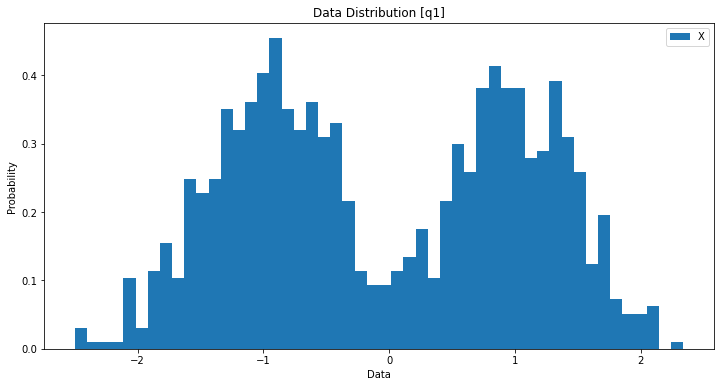

In [4]:
X = GMMsample(gmm=GMM_Model_E1q1, n=1000)

jx_lib.output_hist(
    data_dict = {"X": X},
    figsize = (12,6), bin_size = 50, OUT_DIR = OUT_DIR_E1, tag = "q1"
)

## E1 - Q2: $U_i$ Distribution
- Final Formulation:

$U_i = \Phi^{-1}\left(F(X_i)\right)$
 
where: 

$\Phi^{-1}(F) = \sqrt{2} \,\text{erf}^{-1} (1 - 2F)$

$F(X_i) = \frac12 \left(\frac12 [1 + \,\text{erf}(\frac{X_i - \mu_1}{\sigma_1 \sqrt{2}})] + \frac12 [1 + \,\text{erf}(\frac{X_i - \mu_2}{\sigma_2 \sqrt{2}})] \right)$

- See code and histograms below.

- By inspection, the distribution should be standard normal distribution approximately.

In [5]:
# %% E1q2
def GMMinv(
    X, 
    gmm, 
) -> "nparray":
    # CDF of GMM in q1:
    norm_cdf = lambda x, mu=0, sigma=1 : 0.5 * ( 1 + erf((x - mu) / (sigma * np.sqrt(2))))
    CDF_gmm = lambda x: 0.5 * np.sum([norm_cdf(x, mu, sigma) for mu, sigma in zip(gmm.mu, gmm.sigma)], axis=0)
    F = CDF_gmm(x=X)
    # Inv. CDF of std. normal:
    U = - np.sqrt(2) * erfinv(1 - 2 * F) # EQUIVALENT: U = norm.ppf(F)
    return U


mu=-0.03072942143232806, sigma=0.991168885153809 



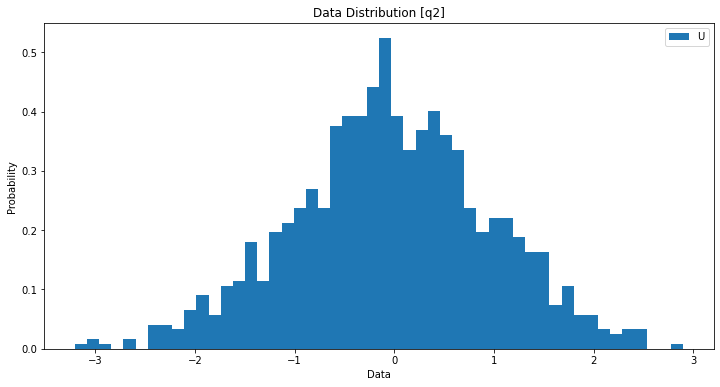

In [6]:
U = GMMinv(X=X, gmm=GMM_Model_E1q1)
print("mu={}, sigma={} \n".format(U.mean(), U.std()))
jx_lib.output_hist(
    data_dict = {"U": U},
    figsize = (12,6), bin_size = 50, OUT_DIR = OUT_DIR_E1, tag = "q2"
)

## E1 - Q3 : Binary Search
- See scripts below.

- See the function T plot with input $z\in [-5, 5]$ below. 

- (Note: I used tol=1e-10 instead of 1e-5 to get a smoother curve)

In [7]:
# %% E1q3
def BinarySearch(
    F: "function",
    u: float, # \in (0,1)
    lb      = -100,
    ub      = 100, 
    maxiter = 100,
    tol     = 1e-10 # 1e-5
):
    while F(lb) > u:
        ub = lb
        lb = lb / 2
    while F(ub) < u:
        lb = ub
        ub = ub * 2
    for i in range(maxiter):
        x = (lb + ub)/2
        t = F(x)

        if t > u:
            ub = x
        else:
            lb = x

        if abs(t-u) <= tol:
            break

    return x

def computeT(
    gmm,
):
    norm_cdf = lambda x, mu=0, sigma=1 : 0.5 * ( 1 + erf((x - mu) / (sigma * np.sqrt(2))))
    CDF_gmm = lambda x: 0.5 * np.sum([norm_cdf(x, mu, sigma) for mu, sigma in zip(gmm.mu, gmm.sigma)], axis=0)
    # CDF_gmm = lambda x: gmm.pi * norm.cdf(x, gmm.mu[0], gmm.sigma[0]) + (1 - gmm.pi) * norm.cdf(x, gmm.mu[1], gmm.sigma[1])
    T_z = lambda z: BinarySearch(F=CDF_gmm, u=norm_cdf(z))
    return T_z

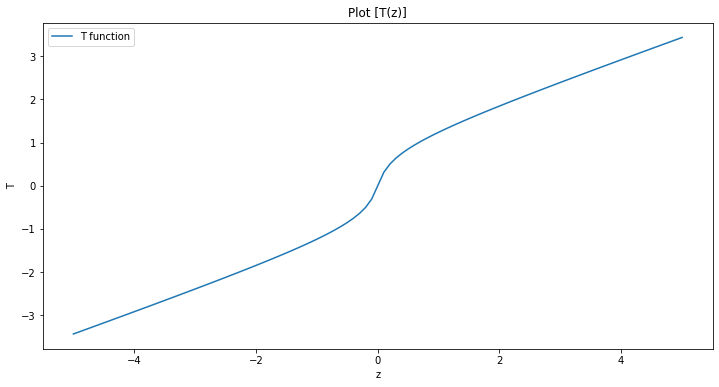

In [8]:
T_z = computeT(gmm=GMM_Model_E1q1)

# plot T_z: 
z_bnd = [-5, 5]
step = 0.1
z_num = np.arange(min(z_bnd), max(z_bnd) + step, step=step)
T_num = np.vectorize(T_z)(z_num)
jx_lib.output_plot(
    data_dict={"T function":{"x":z_num, "y":T_num}},
    Ylabel="T", Xlabel="z", OUT_DIR=OUT_DIR_E1, tag="T(z)"
)

## E1 - Q4 : PushForward
- See histogram of generated $\tilde X_i$ below:

- Script is presented below:

- Resultant Histogram is similar to Ex1.1 (as second comparison histogram shown)

In [9]:
# %% E1q4
def PushForward(
    Z: List[float],
    gmm: GMM,
) -> List[float]:
    # grab T_z:
    T_z = computeT(gmm=gmm)
    Xi_hat = np.vectorize(T_z)(Z)
    return Xi_hat

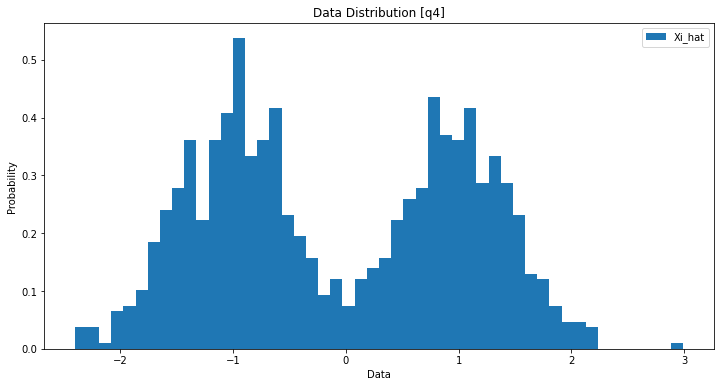

In [10]:
Zi = np.random.normal(0, 1, size=1000)
Xi_hat = PushForward(Z=Zi, gmm=GMM_Model_E1q1)

jx_lib.output_hist(
    data_dict = {"Xi_hat": Xi_hat},
    figsize = (12,6), bin_size = 50, OUT_DIR = OUT_DIR_E1, tag = "q4"
)

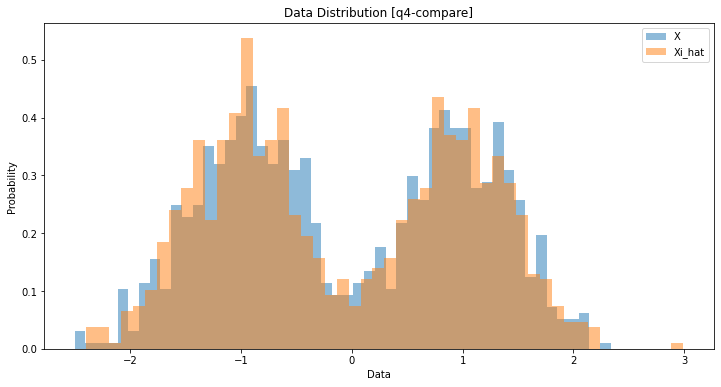

In [11]:
jx_lib.output_hist(
    data_dict = {"X": X, "Xi_hat": Xi_hat},
    figsize = (12,6), bin_size = 50, OUT_DIR = OUT_DIR_E1, tag = "q4-compare"
)

## E1 - Q5 : GMMinv as Ex1.2
- Histogram is as displayed below:

- It is in a form of standard normal distribution by inspection

mu=-0.05068370374537889, sigma=1.0071416249913443 



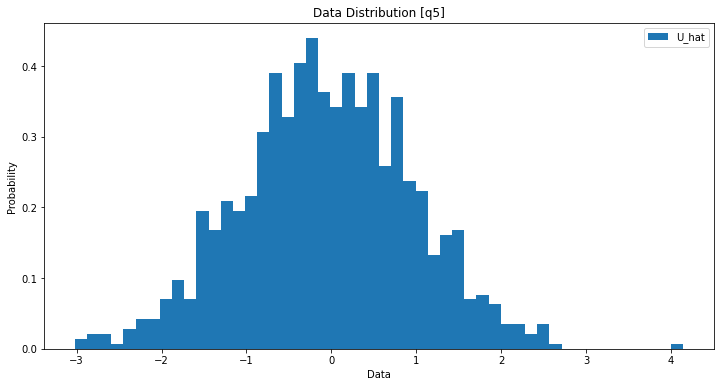

In [12]:
# %% E1q5
U_hat = GMMinv(X=Xi_hat, gmm=GMM_Model_E1q1)
print("mu={}, sigma={} \n".format(U_hat.mean(), U_hat.std()))

jx_lib.output_hist(
    data_dict = {"U_hat": U_hat},
    figsize = (12,6), bin_size = 50, OUT_DIR = OUT_DIR_E1, tag = "q5"
)

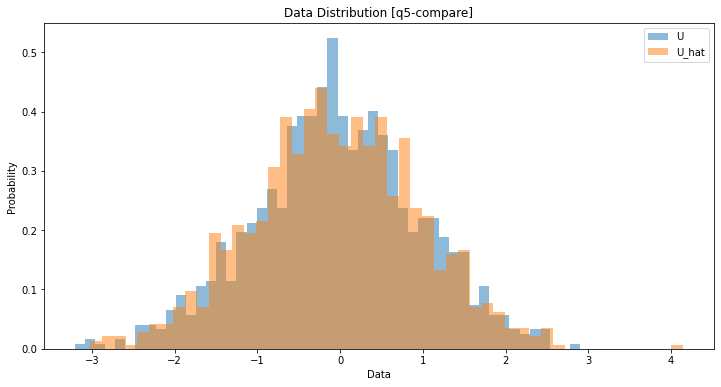

In [13]:
jx_lib.output_hist(
    data_dict = {"U": U, "U_hat": U_hat},
    figsize = (12,6), bin_size = 50, OUT_DIR = OUT_DIR_E1, tag = "q5-compare"
)

## (Optional, 0pt) E1 - Q6 : T as a 2-layer NN